# Preprocessing

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('facial-keypoints-detection/training.csv')

In [21]:
y_full = df.drop(columns=['Image']).values.astype(np.float32)
x_full = [[int(n) for n in img_str.split()] for img_str in df['Image']]
x_full = np.array(x_full, dtype=np.float32).reshape((-1, 96, 96, 1)) / 255

In [22]:
def plot(img, keypoint_sets):
    plt.imshow(img, cmap='grey')
    for y in keypoint_sets:
        key_points = y.reshape((-1, 2))
        plt.scatter(key_points[:, 0], key_points[:, 1])
    plt.show()

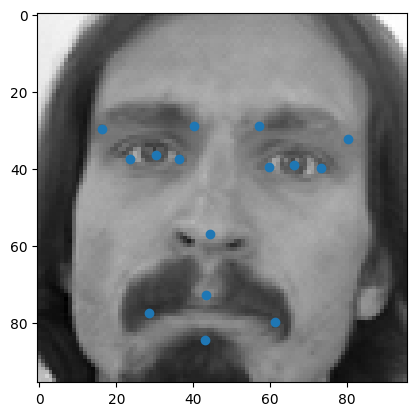

In [23]:
plot(x_full[0], [y_full[0]])

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

x_train_full, x_test, y_train_full, y_test = train_test_split(
    x_full, 
    y_full,
    test_size=0.125,
    shuffle=True,
    random_state=0,
)

imputer = KNNImputer()
y_train_full = imputer.fit_transform(y_train_full)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, 
    y_train_full,
    test_size=0.15,
    shuffle=True,
    random_state=0,
)

print(f'{len(x_train)} train, {len(x_valid)} valid, {len(x_test)} test')

5241 train, 926 valid, 882 test


# Default Model

In [25]:
import tensorflow as tf
from keras import models, layers, losses, optimizers

In [26]:
def get_model(weights_path=None):
    model = models.Sequential((
        layers.Input(shape=(96, 96, 1)),
        layers.Conv2D(64, (3, 3), 
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(32, (3, 3),
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(16, (3, 3), 
                    padding='same', 
                    activation=tf.nn.relu, 
                    use_bias=False),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(30),
    ))

    if weights_path:
        model.load_weights(weights_path)

    model.compile(loss=losses.mean_squared_error, 
                  metrics=[tf.metrics.R2Score()])

    return model

In [27]:
def batch_iterate(x, y, batch_size):
    permutation = np.random.permutation(y.shape[0])
    for s in range(0, y.shape[0], batch_size):
        idxs = permutation[s:s + batch_size]
        yield tf.convert_to_tensor(x[idxs]), tf.convert_to_tensor(y[idxs])

In [36]:
model = get_model('./checkpoints/model1.weights.h5')
optimizer = optimizers.Adam(learning_rate=0.001, weight_decay=0.1)


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

In [37]:
# for epoch in range(100):
#     if (epoch + 1) % 10 == 0:
#         print('epoch:', epoch + 1)
#     for x, y in batch_iterate(x_train, y_train, batch_size=100):
#         train_step(x, y)
#     optimizer.learning_rate *= 0.99

# model.save_weights('./checkpoints/model0.weights.h5')

In [39]:
_ = model.evaluate(x_valid, y_valid)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9239 - r2_score: 0.3330


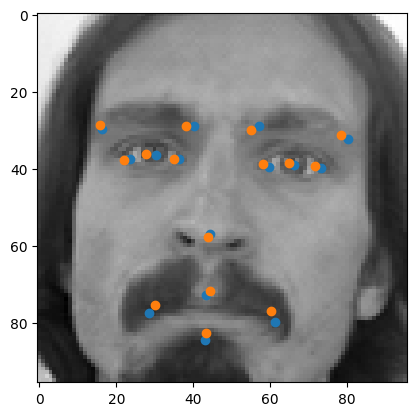

In [40]:
y_pred = model(x_full[:1]).numpy()
plot(x_full[0], [y_full[0], y_pred[0]])

# Attacking the Model

In [41]:
def fgsm(model, x, y, eps):
    delta = tf.Variable(tf.zeros_like(x))
    with tf.GradientTape() as tape:
        y_pred = model(x + delta)
        l = model.loss(y, y_pred)
    grad = tape.gradient(l, delta)
    return eps * tf.sign(grad)

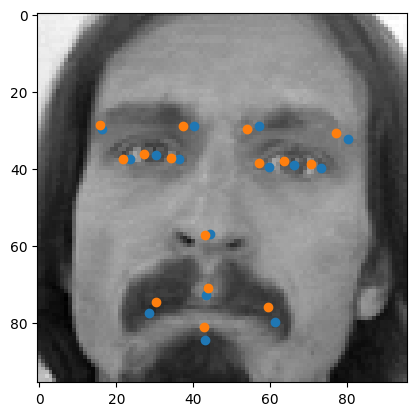

In [42]:
delta = fgsm(model, x_full[:1], y_full[:1], 0.01)
y_pred = model(x_full[:1] + delta).numpy()
plot(x_full[0] + delta[0], [y_full[0], y_pred[0]])

In [43]:
def pgd(model, x, y, eps, alpha=0.001, n_iters=100):
    delta = tf.Variable(tf.zeros_like(x))

    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            y_pred = model(x + delta)
            l = model.loss(y, y_pred)
        grad = tape.gradient(l, delta)
        delta.assign_add(alpha * grad)
        delta.assign(tf.clip_by_value(delta, -eps, eps))
    

    for _ in range(n_iters):
        train_step()

    return delta.value()

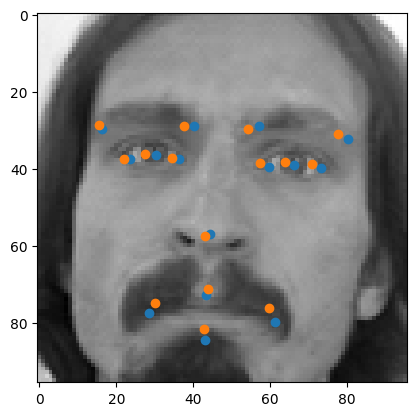

In [44]:
delta = pgd(model, x_full[:1], y_full[:1], 0.01)
y_pred = model(x_full[:1] + delta).numpy()
plot(x_full[0] + delta[0], [y_full[0], y_pred[0]])

In [ ]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)
x_valid_pgd = x_valid  + pgd(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)
print('pgd attack:')
_ = model.evaluate(x_valid_pgd, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2653.3105 - r2_score: -287.3390
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2654.2097 - r2_score: -287.4269
pgd attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2653.7292 - r2_score: -287.3799


# Robust Model

In [53]:
model = get_model()
optimizer = optimizers.Adam(learning_rate=0.001, weight_decay=0.1)
batch_size = 100
delta = tf.Variable(tf.zeros((batch_size, 96, 96, 1)))        
eps = tf.Variable(0.005)


@tf.function
def adversarial_train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

    delta.assign(tf.zeros_like(delta))
    with tf.GradientTape() as tape:
        y_pred = model(x + delta)
        l = model.loss(y, y_pred)
    grad = tape.gradient(l, delta)
    x += eps * tf.sign(grad)

    with tf.GradientTape() as tape:
        y_pred = model(x)
        l = model.loss(y, y_pred)
    grads = tape.gradient(l, model.trainable_variables)
    optimizer.apply(grads, model.trainable_variables)

In [50]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2652.6111 - r2_score: -287.4403
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2653.4500 - r2_score: -287.5323


In [54]:
for epoch in range(10):
    if (epoch + 1) % 5 == 0:
        print('epoch:', epoch + 1)
    for x, y in batch_iterate(x_train, y_train, batch_size=batch_size):
        if len(x) != batch_size:
            continue
        adversarial_train_step(x, y)
    optimizer.learning_rate *= 0.99
    eps.assign_add(0.0001)

model.save_weights('./checkpoints/robust_model0.weights.h5')

epoch: 5
epoch: 10


In [55]:
x_valid_fgsm = x_valid + fgsm(model, x_valid, y_valid, 0.01)

print('no attack:')
_ = model.evaluate(x_valid, y_valid)
print('fgsm attack:')
_ = model.evaluate(x_valid_fgsm, y_valid)

no attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.8244 - r2_score: -0.0159
fgsm attack:
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.0944 - r2_score: -0.0397


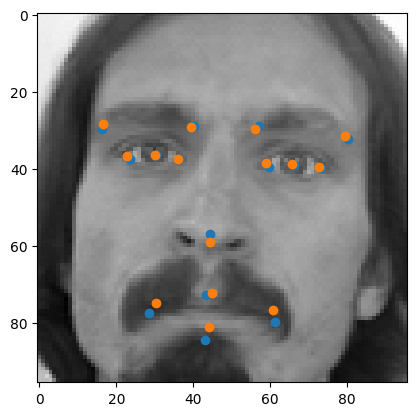

In [ ]:
y_pred = model(x_full[0:1]).numpy()
plot(x_full[0], [y_full[0], y_pred[0]])

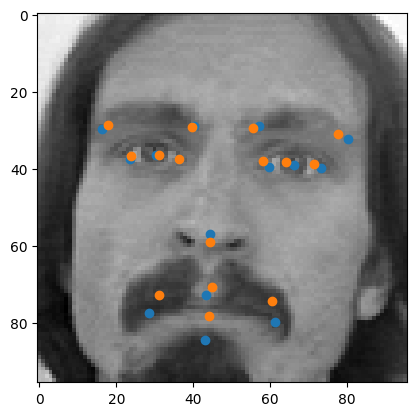

In [ ]:
delta = fgsm(model, x_full[:1], y_full[:1], 0.01)
y_pred = model(x_full[:1] + delta).numpy()
plot(x_full[0] + delta[0], [y_full[0], y_pred[0]])